In [1]:
import numpy as np
import pandas as pd

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
      #  print(os.path.join(dirname, filename))

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import sklearn 
import warnings
warnings.filterwarnings('ignore')


df = pd.read_csv("../input/common-voice/cv-valid-train.csv")
df[df['age'].notna()].head()

,filename,text,up_votes,down_votes,age,gender,accent,duration
5,cv-valid-train/sample-000005.mp3,a shepherd may like to travel but he should ne...,1,0,twenties,female,us,NaN
8,cv-valid-train/sample-000008.mp3,put jackie right on the staff,3,0,seventies,male,us,NaN
13,cv-valid-train/sample-000013.mp3,but he had found a guide and didn't want to mi...,1,0,thirties,female,us,NaN
14,cv-valid-train/sample-000014.mp3,as they began to decorate the hallway a silhou...,1,0,sixties,male,england,NaN
19,cv-valid-train/sample-000019.mp3,then they got ahold of some dough and went goofy,1,0,fifties,male,australia,NaN


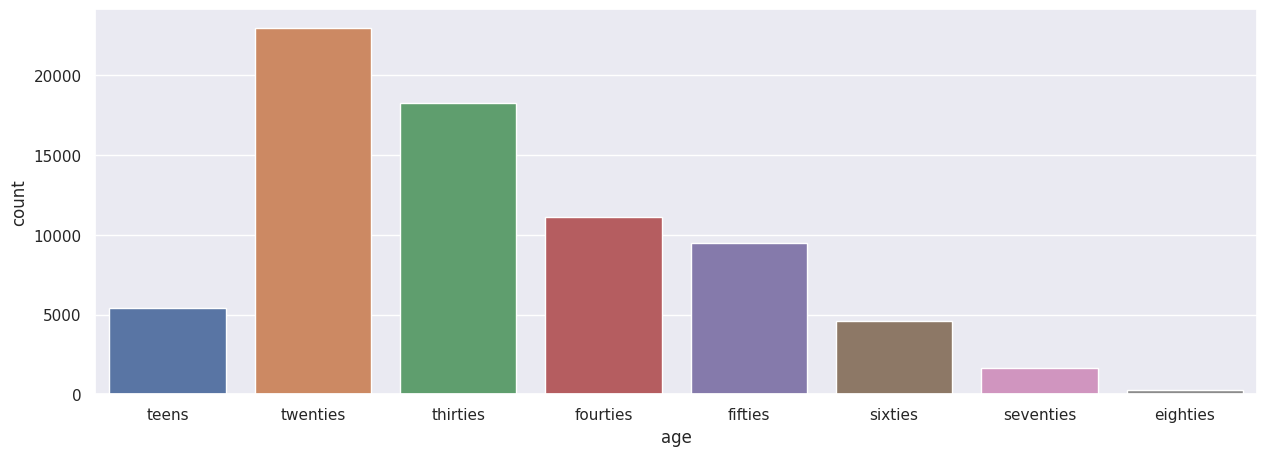

In [3]:
sns.set(rc={'figure.figsize':(15, 5)})
sns.countplot(x="age",
        data=df[df['age'].notna()],
        order=['teens', 'twenties', 'thirties', 'fourties', 'fifties', 'sixties', 'seventies', 'eighties'])

plt.show()

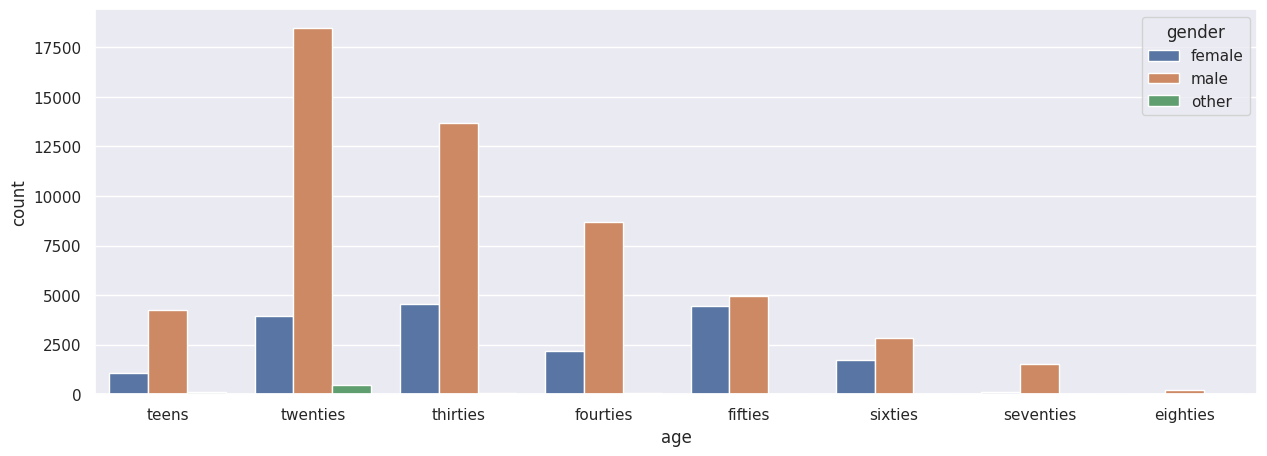

In [4]:
sns.countplot(x="age",
        hue='gender',
        data=df[df['age'].notna()],
        order=['teens', 'twenties', 'thirties', 'fourties', 'fifties', 'sixties', 'seventies', 'eighties'])

plt.show()

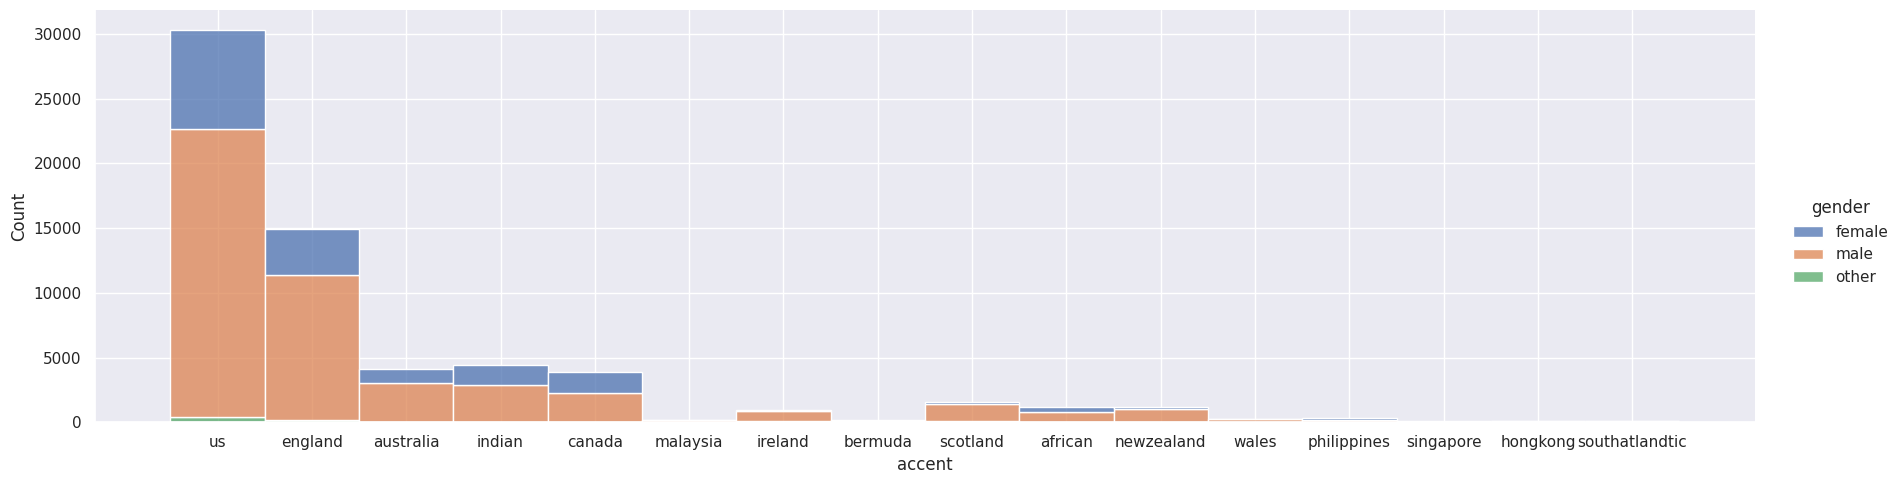

In [5]:
sns.displot(x="accent",
        data=df[df['accent'].notna()],
        hue='gender',
        multiple='stack',
        height=5, aspect=18/5)

plt.show()

In [ ]:
# Selecting initial relevant columns
df_cleaned = df[['filename','age','gender','accent']] # Keep accent for initial NaN check

#To clean the data we remove the sample with NaN attribute values for these key columns.
data = df_cleaned[df_cleaned['age'].notna() & df_cleaned['gender'].notna() & df_cleaned['accent'].notna()].copy() 

# Now, selecting only the columns needed for the features dataframe and gender/age labels
data = data[['filename','age','gender']]

data.reset_index(inplace=True, drop=True)
start_shape = df.shape
end_shape = data.shape
print("Initial df shape: {} Final data shape after NaN removal for age, gender, accent: {}".format(start_shape, end_shape))
print("Shape of 'data' for feature extraction:", data.shape)
data.head()

Initial df shape: (195776, 8) Final data shape after NaN removal for age, gender, accent: (63163, 3)
Shape of 'data' for feature extraction: (63163, 3)


,filename,age,gender
0,cv-valid-train/sample-000005.mp3,twenties,female
1,cv-valid-train/sample-000008.mp3,seventies,male
2,cv-valid-train/sample-000013.mp3,thirties,female
3,cv-valid-train/sample-000014.mp3,sixties,male
4,cv-valid-train/sample-000019.mp3,fifties,male


In [ ]:

# data['gender'] = pd.to_numeric(data['gender'],errors = 'coerce')
# data.dtypes
cleanup_nums = {"gender": {"male":1,"female":0,"other":0.5}}
data.replace(cleanup_nums, inplace=True) 
data.head()

,filename,age,gender
0,cv-valid-train/sample-000005.mp3,twenties,0.0
1,cv-valid-train/sample-000008.mp3,seventies,1.0
2,cv-valid-train/sample-000013.mp3,thirties,0.0
3,cv-valid-train/sample-000014.mp3,sixties,1.0
4,cv-valid-train/sample-000019.mp3,fifties,1.0


In [ ]:
import librosa
ds_path = "/kaggle/input/common-voice/cv-valid-train/" 

#this function is used to extract audio frequency features FOR TRAINING DATAFRAME
# It includes gender as the first feature, which will become a column in df_features
def feature_extraction_for_training(filename, sampling_rate=48000):
    path = "{}{}".format(ds_path, filename)
    features_list = list() # Renamed to avoid conflict with the global 'features' variable 
    try:
        audio, _ = librosa.load(path, sr=sampling_rate)

        gender_val = data[data['filename'] == filename].gender.values[0]
        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sampling_rate))
        spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sampling_rate))
        spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sampling_rate))
        features_list.append(gender_val) # Gender is the first feature here
        features_list.append(spectral_centroid)
        features_list.append(spectral_bandwidth)
        features_list.append(spectral_rolloff)

        mfcc = librosa.feature.mfcc(y=audio, sr=sampling_rate, n_mfcc=20) # Specify n_mfcc
        for el in mfcc:
            features_list.append(np.mean(el))

        return features_list
    except Exception as e:
        print(f"Error processing {filename}: {e}")
        return None # Return None if there's an error


# Test the function with one file
if not data.empty:
    test_features = feature_extraction_for_training(data.iloc[0]['filename'])
    print("Features for one file (including gender as first element): ", test_features)
    print(f"Number of features extracted (incl. gender): {len(test_features) if test_features else 'Error'}") # Should be 1 (gender) + 3 (spectral) + 20 (MFCC) = 24
else:
    print("Data is empty, cannot test feature_extraction_for_training.")

Features for one file (including gender as first element):  [0.0, 2147.6058802457837, 2430.474971071776, 4428.830553016453, -625.28143, 111.306145, 6.3690853, 34.7671, 31.623457, -4.7215633, -0.51193386, -4.9454904, -12.71285, -2.0436714, -3.7277246, -10.708405, -11.206564, -12.003515, -8.506438, -5.472296, -4.950396, -3.7100523, -6.314986, -6.328086]
Number of features extracted (incl. gender): 24


In [ ]:
#the function create dataframe to store the feature and label related to each other
def create_df_features(orig_data):
    new_rows = list()
    tot_rows = len(orig_data)
    stop_counter = len(orig_data)

    for idx, row in orig_data.iterrows():
        if idx >= stop_counter: break
        print("\r", end="")
        print("Processing: {}/{}".format(idx+1, min(tot_rows, stop_counter)), end="", flush=True)
        
        extracted_features = feature_extraction_for_training(row['filename'])
        if extracted_features: # Checking if feature extraction was successful
            extracted_features.append(row['age']) # Age is the label
            new_rows.append(extracted_features)
        else:
            print(f"Skipping file {row['filename']} due to extraction error.")

    print("\nFeature extraction complete.")
    # Column names: gender + 3 spectral + 20 MFCCs + 1 label (age) = 25 columns
    return pd.DataFrame(new_rows, columns=["gender_feat", "spectral_centroid", "spectral_bandwidth", "spectral_rolloff",
                                    "mfcc1", "mfcc2", "mfcc3", "mfcc4", "mfcc5", "mfcc6", "mfcc7", "mfcc8",
                                   "mfcc9", "mfcc10", "mfcc11", "mfcc12", "mfcc13", "mfcc14", "mfcc15", "mfcc16",
                                   "mfcc17", "mfcc18", "mfcc19", "mfcc20", "age_label"])
    
if 'data' in globals() and not data.empty:
    df_features = create_df_features(data)
    if not df_features.empty:
        print(df_features.head())
        # Saving the extracted features to a CSV file
        df_features.to_csv("audio_features_with_labels.csv", index=False)
        print("\nFeatures DataFrame saved to audio_features_with_labels.csv")
    else:
        print("df_features is empty after processing.")
else:
    print("Variable 'data' is not defined or is empty. Cannot create df_features.")

Processing: 63163/63163
Feature extraction complete.
   gender_feat  spectral_centroid  spectral_bandwidth  spectral_rolloff  \
0          0.0        2147.605880         2430.474971       4428.830553   
1          1.0        2815.325442         2451.922348       4884.633819   
2          0.0        1844.637736         1491.011524       3164.948048   
3          1.0        2123.711333         2202.012929       4111.215965   
4          1.0        2360.672044         2957.220240       4767.080050   

        mfcc1       mfcc2      mfcc3      mfcc4      mfcc5      mfcc6  ...  \
0 -625.281433  111.306145   6.369085  34.767101  31.623457  -4.721563  ...   
1 -469.936646  126.283386 -16.548649   3.546792   2.184188  13.748076  ...   
2 -418.205475  147.666870 -49.974003  -2.286364  37.185310  -8.906048  ...   
3 -464.910706  118.437225  19.749662  27.143229  26.438824   2.309232  ...   
4 -343.833008  157.153885   7.661150  41.898964 -15.152472  28.925106  ...   

      mfcc12     mfcc13    

In [ ]:

if 'df_features' not in globals() or df_features.empty:
    try:
        print("Attempting to load features from audio_features_with_labels.csv...")
        df_features = pd.read_csv("audio_features_with_labels.csv")
        if df_features.empty:
            print("Loaded CSV is empty. Please ensure Cell 9 (create_df_features) ran successfully and created a non-empty CSV.")
        else:
            print("Successfully loaded features from CSV.")
            print(df_features.head())
    except FileNotFoundError:
        print("audio_features_with_labels.csv not found. Please run Cell 9 (create_df_features) first.")
else:
    print("df_features already exists in memory.")

# --- Make sure df_features is not empty before proceeding ---
if 'df_features' not in globals() or df_features.empty:
    print("\nERROR: df_features is not available or is empty. Cannot proceed with model training.")
    print("Please ensure feature extraction (Cell 9) was successful and 'audio_features_with_labels.csv' exists and is populated, or re-run Cell 9.")
else:
    print(f"\nProceeding with df_features of shape: {df_features.shape}")

df_features already exists in memory.

Proceeding with df_features of shape: (63163, 25)


In [11]:
from sklearn.preprocessing import StandardScaler

def scale_features(features_df, label_column_name):
    scaler = StandardScaler()
    # We scale all columns EXCEPT the label column
    X_to_scale = np.array(features_df.drop(columns=[label_column_name]), dtype = float)
    scaled_data = scaler.fit_transform(X_to_scale)
    return scaled_data, scaler

if 'df_features' in globals() and not df_features.empty:
    # For age prediction, the features are all columns except 'age_label'
    X_age_scaled, scaler_age = scale_features(df_features, 'age_label')
    print("Shape of X_age_scaled:", X_age_scaled.shape)
else:
    print("df_features not available for scaling (Age).")

Shape of X_age_scaled: (63163, 24)


In [12]:
if 'df_features' in globals() and not df_features.empty and 'X_age_scaled' in globals():
    print("Before scaling (first row, features for age):", df_features.drop(columns=['age_label']).iloc[0].values)
    print("\nAfter scaling (first row, features for age):", X_age_scaled[0])
else:
    print("Cannot display scaled features; df_features or X_age_scaled not available.")

Before scaling (first row, features for age): [ 0.00000000e+00  2.14760588e+03  2.43047497e+03  4.42883055e+03
 -6.25281433e+02  1.11306145e+02  6.36908531e+00  3.47671013e+01
  3.16234570e+01 -4.72156334e+00 -5.11933863e-01 -4.94549036e+00
 -1.27128496e+01 -2.04367137e+00 -3.72772455e+00 -1.07084045e+01
 -1.12065639e+01 -1.20035152e+01 -8.50643826e+00 -5.47229624e+00
 -4.95039606e+00 -3.71005225e+00 -6.31498623e+00 -6.32808590e+00]

After scaling (first row, features for age): [-1.6745565  -0.6828973  -0.11538481 -0.40646969 -2.03623671 -0.18468259
  0.52276417  0.79339923  1.69668163 -0.85493049  0.16133489 -0.25919818
 -1.08391695  0.45809113 -0.00559533 -1.21081899 -1.72753231 -1.33762603
 -1.1995814  -0.56091972 -0.35339387 -0.50756062 -1.02775155 -0.639721  ]


In [13]:
from sklearn.preprocessing import LabelEncoder

def get_labels(features_df, label_column_name):
    labels = features_df[label_column_name]
    encoder = LabelEncoder()
    encoded_labels = encoder.fit_transform(labels)
    return encoded_labels, encoder

if 'df_features' in globals() and not df_features.empty:
    y_age, encoder_age = get_labels(df_features, 'age_label')
    classes_age = encoder_age.classes_
    print("Unique age labels before encoding:", df_features['age_label'].unique())
    print("\nAfter encoding (first age label):", y_age[0])
    print("Class mapping for age:", dict(zip(encoder_age.classes_, encoder_age.transform(encoder_age.classes_))))
    print("\nClasses (age):", classes_age)
else:
    print("df_features not available for label encoding (Age).")

Unique age labels before encoding: ['twenties' 'seventies' 'thirties' 'sixties' 'fifties' 'fourties' 'teens'
 'eighties']

After encoding (first age label): 7
Class mapping for age: {'eighties': 0, 'fifties': 1, 'fourties': 2, 'seventies': 3, 'sixties': 4, 'teens': 5, 'thirties': 6, 'twenties': 7}

Classes (age): ['eighties' 'fifties' 'fourties' 'seventies' 'sixties' 'teens' 'thirties'
 'twenties']


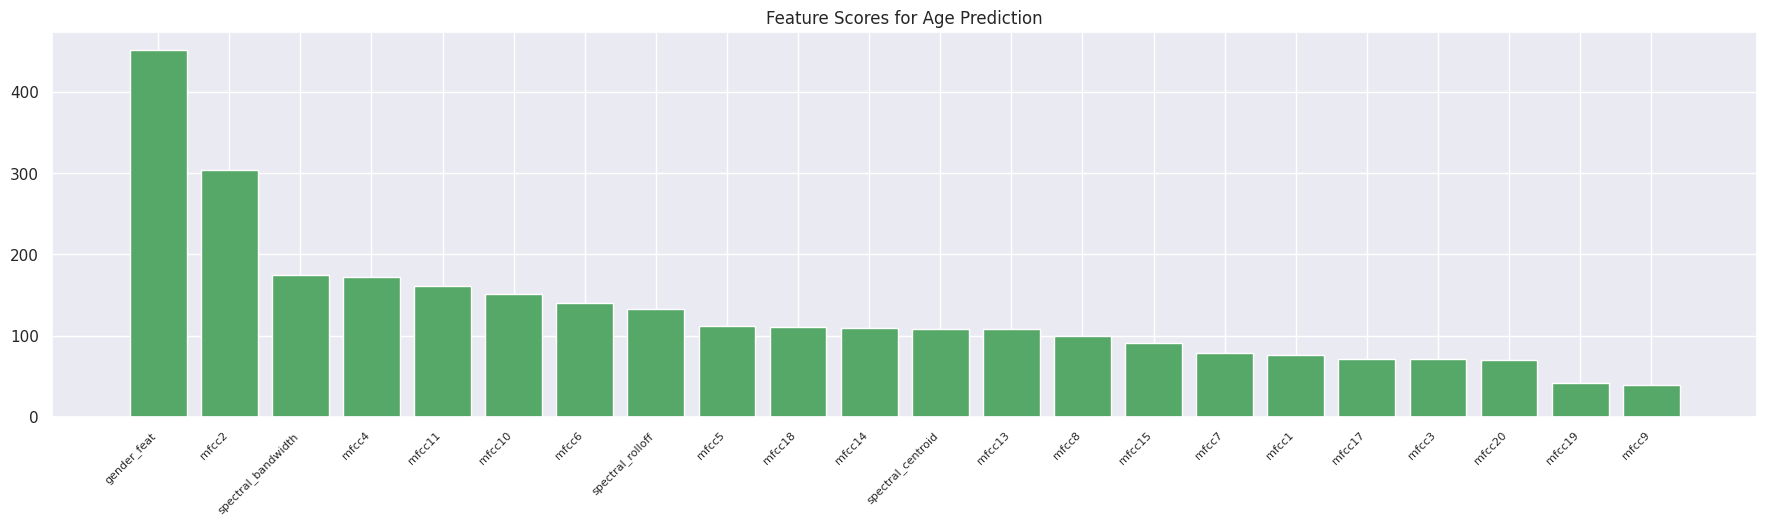

Shape of X_age_selected: (63163, 22)


In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

if 'X_age_scaled' in globals() and 'y_age' in globals():
    # Number of features to select (all input features for age prediction, which is df_features.shape[1]-1)
    # The input features for age are gender_feat + 3 spectral + 20 MFCCs = 24 features
    n_features_age = 22 

    f_selector_age = SelectKBest(f_classif, k=n_features_age).fit(X_age_scaled, y_age)
    X_age_selected = f_selector_age.transform(X_age_scaled)
    scores_age = f_selector_age.scores_

    feature_names_for_age = df_features.drop(columns=['age_label']).columns
    
    indices_age = np.argsort(scores_age)[::-1]

    selected_features_display_age = []
    for i in range(n_features_age):
        selected_features_display_age.append(feature_names_for_age[indices_age[i]])

    plt.figure(figsize=(22, 5))
    plt.bar(selected_features_display_age, scores_age[indices_age[range(n_features_age)]], color='g')
    plt.xticks(fontsize=8, rotation=45, ha="right")
    plt.title("Feature Scores for Age Prediction")
    plt.show()
    print("Shape of X_age_selected:", X_age_selected.shape)
else:
    print("X_age_scaled or y_age not available for feature selection.")

In [15]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

if 'X_age_selected' in globals() and 'y_age' in globals():
    classifiers_and_params_age = [
        (SVC(random_state=42), {'C': [100, 150], 'gamma': ['auto', 'scale']}), # Reduced C for faster test
        (RandomForestClassifier(random_state=42), {'n_estimators': [100, 150]}) # Reduced n_estimators
    ]
    
    best_age_model_overall = None
    best_age_f1_overall = 0

    for tup_age in classifiers_and_params_age:
        print(f"Training Age Model: {tup_age[0].__class__.__name__}")
        outer_cv_age = KFold(n_splits=3, shuffle=True, random_state=0)
        fold_counter_age = 0
        results_age = []

        for train_idx_age, test_idx_age in outer_cv_age.split(X_age_selected):
            fold_counter_age += 1
            X_train_age, X_test_age = X_age_selected[train_idx_age], X_age_selected[test_idx_age]
            y_train_age, y_test_age = y_age[train_idx_age], y_age[test_idx_age]

            inner_cv_age = KFold(n_splits=2, shuffle=True, random_state=0)
            gs_age = GridSearchCV(tup_age[0], tup_age[1], scoring='f1_macro', cv=inner_cv_age, refit=True, n_jobs=-1)
            res_age = gs_age.fit(X_train_age, y_train_age)
            
            best_model_fold_age = res_age.best_estimator_
            pred_age = best_model_fold_age.predict(X_test_age)
            score_age = f1_score(y_test_age, pred_age, average='macro')
            results_age.append(score_age)
            
            print(f"\tFold {fold_counter_age}, Best Params {res_age.best_params_} with F1 {res_age.best_score_:.3f}, Test F1 {score_age:.3f}")
            
            if score_age > best_age_f1_overall:
                best_age_f1_overall = score_age
                best_age_model_overall = best_model_fold_age
        
        print(f'\tAverage F1 Score on Test Set for {tup_age[0].__class__.__name__}: {np.mean(results_age):.3f}\n')

    print(f"Overall best age model type: {type(best_age_model_overall)} with F1 score: {best_age_f1_overall:.3f}")
else:
    print("X_age_selected or y_age not available for model training.")

Training Age Model: SVC
	Fold 1, Best Params {'C': 100, 'gamma': 'auto'} with F1 0.804, Test F1 0.863
	Fold 2, Best Params {'C': 100, 'gamma': 'auto'} with F1 0.806, Test F1 0.865
	Fold 3, Best Params {'C': 100, 'gamma': 'auto'} with F1 0.807, Test F1 0.864
	Average F1 Score on Test Set for SVC: 0.864

Training Age Model: RandomForestClassifier
	Fold 1, Best Params {'n_estimators': 150} with F1 0.708, Test F1 0.777
	Fold 2, Best Params {'n_estimators': 150} with F1 0.710, Test F1 0.774
	Fold 3, Best Params {'n_estimators': 150} with F1 0.710, Test F1 0.773
	Average F1 Score on Test Set for RandomForestClassifier: 0.775

Overall best age model type: <class 'sklearn.svm._classes.SVC'> with F1 score: 0.865


In [ ]:
import itertools

def my_plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha="right")
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    fmt = ".2f" if normalize else "d"
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


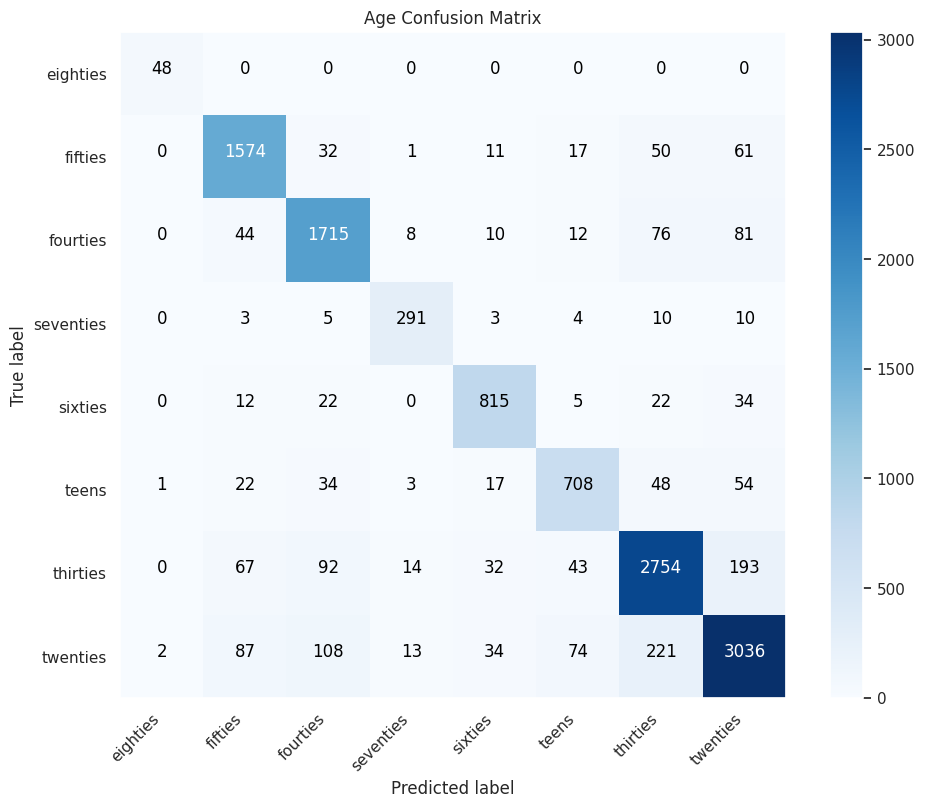

Normalized confusion matrix


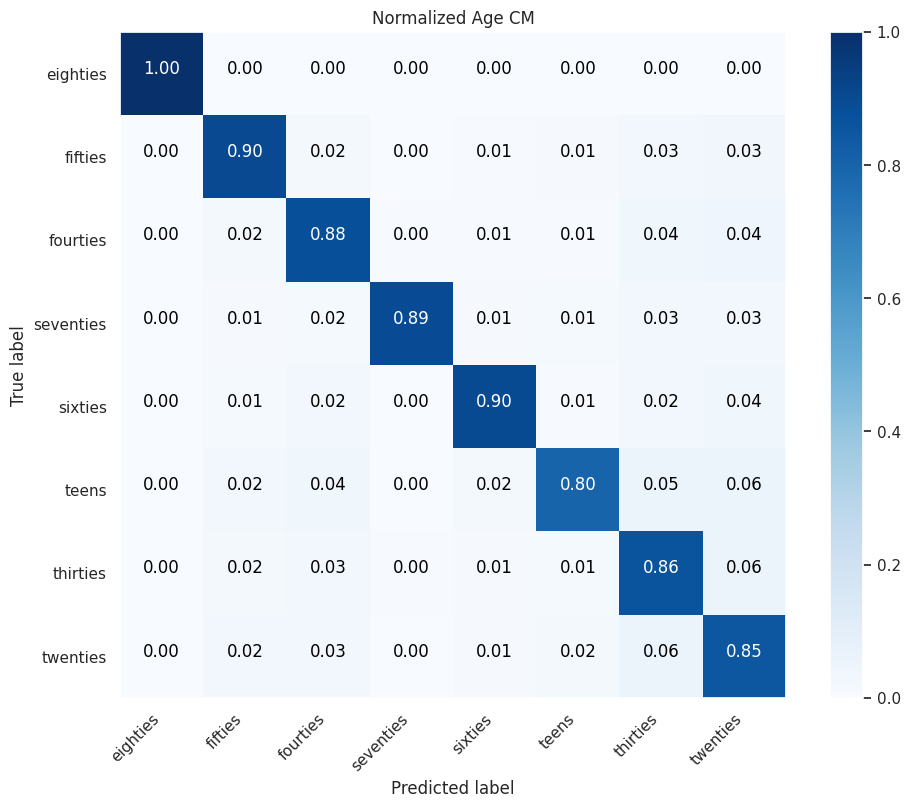

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

if 'best_age_model_overall' in globals() and best_age_model_overall is not None and \
   'X_age_selected' in globals() and 'y_age' in globals() and 'classes_age' in globals():
    
    X_train_age_final, X_test_age_final, y_train_age_final, y_test_age_final = train_test_split(
        X_age_selected, y_age, test_size=0.2, random_state=0, stratify=y_age 
    )

    best_age_model_overall.fit(X_train_age_final, y_train_age_final)
    y_pred_age_final = best_age_model_overall.predict(X_test_age_final)

    cm_age = confusion_matrix(y_test_age_final, y_pred_age_final)

    plt.figure(figsize=(10, 8))
    my_plot_confusion_matrix(cm_age, classes=classes_age, title='Age Confusion Matrix')
    plt.grid(False)
    plt.show()

    # Plot normalized confusion matrix
    plt.figure(figsize=(10, 8))
    my_plot_confusion_matrix(cm_age, classes=classes_age, normalize=True, title='Normalized Age CM')
    plt.grid(False)
    plt.show()
else:
    print("Cannot plot age confusion matrix: Best age model or data not available.")

In [18]:
import joblib

if 'best_age_model_overall' in globals() and best_age_model_overall is not None and \
   'scaler_age' in globals() and 'f_selector_age' in globals() and 'encoder_age' in globals():
    
    joblib.dump(best_age_model_overall, 'age_prediction_model.sav')
    joblib.dump(scaler_age, 'age_scaler.pkl')
    joblib.dump(f_selector_age, 'age_feature_selector.pkl')
    joblib.dump(encoder_age, 'age_label_encoder.pkl')
    print("Age model and transformers saved.")
else:
    print("Could not save age model/transformers: one or more components are missing.")

Age model and transformers saved.


In [ ]:
if 'df_features' in globals() and not df_features.empty:
    # Features for gender prediction are spectral_centroid to mfcc20
    # The 'gender_feat' column is our target for gender prediction.
    # 'age_label' is the target for age prediction and should not be a feature for gender.
    
    feature_cols_for_gender_input = [col for col in df_features.columns if col not in ['gender_feat', 'age_label']]
    
    X_gender_raw = df_features[feature_cols_for_gender_input].copy()
    y_gender_raw = df_features['gender_feat'].copy()

   
    valid_gender_indices = y_gender_raw.isin([0.0, 1.0])
    X_gender_clean = X_gender_raw[valid_gender_indices].copy()
    y_gender_clean = y_gender_raw[valid_gender_indices].astype(int).copy() # Convert to int (0 or 1)

    print(f"Shape of X for gender: {X_gender_clean.shape}")
    print(f"Shape of y for gender: {y_gender_clean.shape}")
    print("Gender value counts for training:\n", y_gender_clean.value_counts())
    
    if X_gender_clean.empty or y_gender_clean.empty:
        print("ERROR: No data available for gender prediction after cleaning.")
    else:
        print("Data for gender prediction prepared.")
else:
    print("df_features not available for gender data preparation.")

Shape of X for gender: (62421, 23)
Shape of y for gender: (62421,)
Gender value counts for training:
 gender_feat
1    46002
0    16419
Name: count, dtype: int64
Data for gender prediction prepared.


In [20]:
if 'X_gender_clean' in globals() and not X_gender_clean.empty:
    scaler_gender = StandardScaler()
    X_gender_scaled = scaler_gender.fit_transform(np.array(X_gender_clean, dtype=float))
    print("Shape of X_gender_scaled:", X_gender_scaled.shape)
else:
    print("X_gender_clean not available for scaling.")

Shape of X_gender_scaled: (62421, 23)


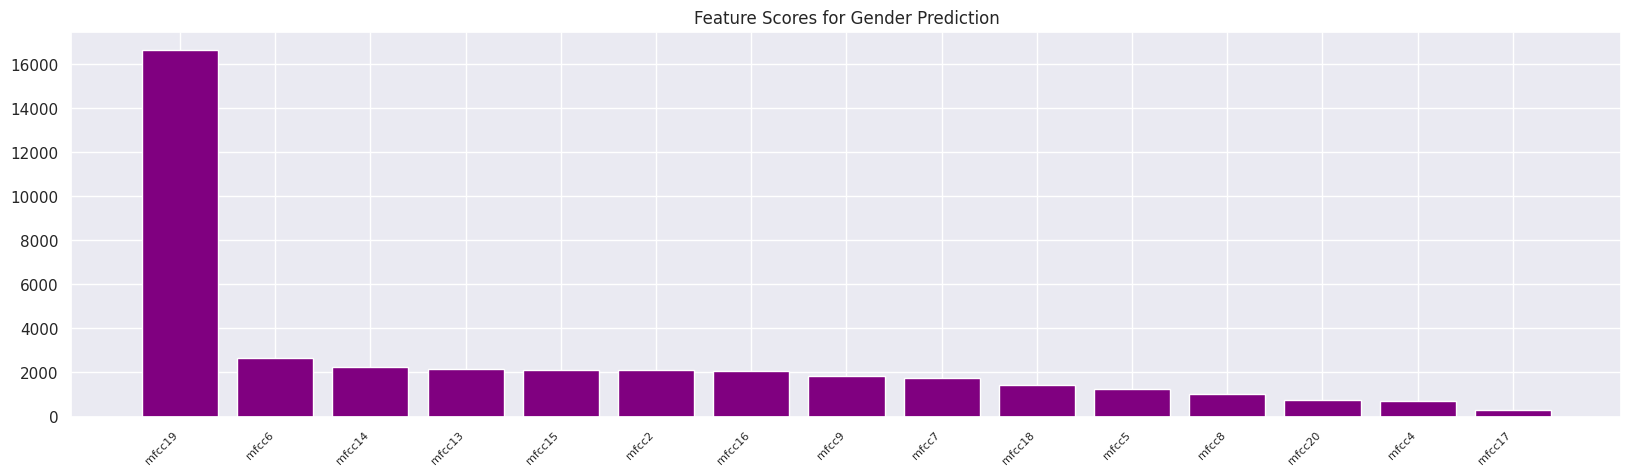

Shape of X_gender_selected: (62421, 15)


In [ ]:
if 'X_gender_scaled' in globals() and 'y_gender_clean' in globals() and not y_gender_clean.empty:
    # Number of features for gender input is X_gender_clean.shape[1] (should be 23: 3 spectral + 20 MFCCs)
    n_features_gender = 15 
    if n_features_gender > X_gender_scaled.shape[1]:
        n_features_gender = X_gender_scaled.shape[1] # Adjust if k is too large
        print(f"Adjusted n_features_gender to {n_features_gender}")


    f_selector_gender = SelectKBest(f_classif, k=n_features_gender).fit(X_gender_scaled, y_gender_clean)
    X_gender_selected = f_selector_gender.transform(X_gender_scaled)
    scores_gender = f_selector_gender.scores_
    
    # Get column names for gender features
    feature_names_for_gender = X_gender_clean.columns

    indices_gender = np.argsort(scores_gender)[::-1]
    selected_feature_names_gender_display = [feature_names_for_gender[i] for i in indices_gender[:n_features_gender]]

    plt.figure(figsize=(20, 5))
    plt.bar(selected_feature_names_gender_display, scores_gender[indices_gender[:n_features_gender]], color='purple')
    plt.xticks(fontsize=8, rotation=45, ha="right")
    plt.title("Feature Scores for Gender Prediction")
    plt.show()
    print("Shape of X_gender_selected:", X_gender_selected.shape)
else:
    print("X_gender_scaled or y_gender_clean not available for gender feature selection.")

In [22]:
if 'X_gender_selected' in globals() and 'y_gender_clean' in globals() and not y_gender_clean.empty:
    classifiers_and_params_gender = [
        (SVC(random_state=42), {'C': [1, 10, 100], 'gamma': ['auto', 'scale'], 'kernel': ['rbf']}),
        (RandomForestClassifier(random_state=42), {'n_estimators': [100, 150], 'max_depth': [10, 20]})
    ]
    
    best_gender_model_overall = None
    best_gender_f1_overall = 0

    for tup_gender in classifiers_and_params_gender:
        print(f"Training Gender Model: {tup_gender[0].__class__.__name__}")
        outer_cv_gender = KFold(n_splits=3, shuffle=True, random_state=42)
        fold_counter_gender = 0
        results_gender = []

        for train_idx_g, test_idx_g in outer_cv_gender.split(X_gender_selected):
            fold_counter_gender += 1
            X_train_g, X_test_g = X_gender_selected[train_idx_g], X_gender_selected[test_idx_g]
            y_train_g, y_test_g = y_gender_clean.iloc[train_idx_g], y_gender_clean.iloc[test_idx_g]

            inner_cv_gender = KFold(n_splits=2, shuffle=True, random_state=42)
            gs_gender = GridSearchCV(tup_gender[0], tup_gender[1], scoring='f1_macro', cv=inner_cv_gender, refit=True, n_jobs=-1)
            res_gender = gs_gender.fit(X_train_g, y_train_g)
            
            best_model_fold_gender = res_gender.best_estimator_
            pred_gender = best_model_fold_gender.predict(X_test_g)
            score_gender = f1_score(y_test_g, pred_gender, average='macro') # Use macro for binary too for consistency
            results_gender.append(score_gender)
            
            print(f"\tFold {fold_counter_gender}, Best Params {res_gender.best_params_} with F1 {res_gender.best_score_:.3f}, Test F1 {score_gender:.3f}")
            
            if score_gender > best_gender_f1_overall:
                best_gender_f1_overall = score_gender
                best_gender_model_overall = best_model_fold_gender # Save the actual best model
        
        print(f'\tAverage F1 Score on Test Set for {tup_gender[0].__class__.__name__}: {np.mean(results_gender):.3f}\n')
        
    print(f"Overall best gender model type: {type(best_gender_model_overall)} with F1 score: {best_gender_f1_overall:.3f}")
else:
    print("X_gender_selected or y_gender_clean not available for gender model training.")

Training Gender Model: SVC
	Fold 1, Best Params {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'} with F1 0.885, Test F1 0.899
	Fold 2, Best Params {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'} with F1 0.882, Test F1 0.897
	Fold 3, Best Params {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'} with F1 0.884, Test F1 0.901
	Average F1 Score on Test Set for SVC: 0.899

Training Gender Model: RandomForestClassifier
	Fold 1, Best Params {'max_depth': 20, 'n_estimators': 100} with F1 0.834, Test F1 0.845
	Fold 2, Best Params {'max_depth': 20, 'n_estimators': 150} with F1 0.831, Test F1 0.844
	Fold 3, Best Params {'max_depth': 20, 'n_estimators': 150} with F1 0.832, Test F1 0.846
	Average F1 Score on Test Set for RandomForestClassifier: 0.845

Overall best gender model type: <class 'sklearn.svm._classes.SVC'> with F1 score: 0.901


Confusion matrix, without normalization


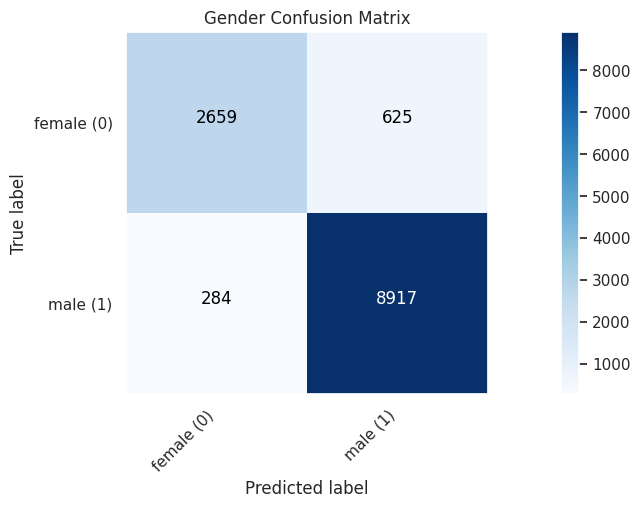

Normalized confusion matrix


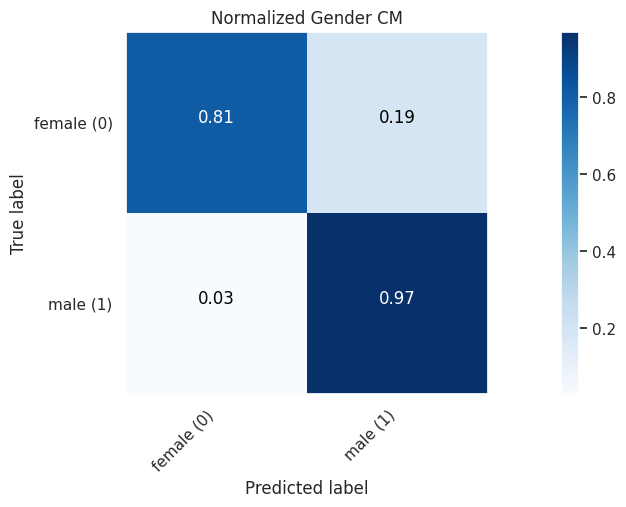

In [23]:
if 'best_gender_model_overall' in globals() and best_gender_model_overall is not None and \
   'X_gender_selected' in globals() and 'y_gender_clean' in globals() and not y_gender_clean.empty:
    
    X_train_g_final, X_test_g_final, y_train_g_final, y_test_g_final = train_test_split(
        X_gender_selected, y_gender_clean, test_size=0.2, random_state=123, stratify=y_gender_clean
    )
    
    # Refit the overall best model
    best_gender_model_overall.fit(X_train_g_final, y_train_g_final)
    y_pred_g_final = best_gender_model_overall.predict(X_test_g_final)
    cm_gender = confusion_matrix(y_test_g_final, y_pred_g_final)
    
    gender_classes_display = ["female (0)", "male (1)"] # Based on our encoding

    plt.figure()
    my_plot_confusion_matrix(cm_gender, classes=gender_classes_display, title="Gender Confusion Matrix")
    plt.grid(False); plt.show()

    plt.figure()
    my_plot_confusion_matrix(cm_gender, classes=gender_classes_display, normalize=True, title="Normalized Gender CM")
    plt.grid(False); plt.show()
else:
    print("Cannot plot gender confusion matrix: Best gender model or data not available.")

In [24]:
if 'best_gender_model_overall' in globals() and best_gender_model_overall is not None and \
   'scaler_gender' in globals() and 'f_selector_gender' in globals():
    
    joblib.dump(best_gender_model_overall, 'gender_prediction_model.sav')
    joblib.dump(scaler_gender, 'gender_scaler.pkl')
    joblib.dump(f_selector_gender, 'gender_feature_selector.pkl')
    print("Gender model and transformers saved.")
else:
    print("Could not save gender model/transformers: one or more components are missing.")

Gender model and transformers saved.


In [ ]:
import joblib
import numpy as np
import librosa 

if 'ds_path' not in globals():
    ds_path = "/kaggle/input/common-voice/cv-valid-train/"


try:
    # Age Prediction Assets
    loaded_age_model = joblib.load('age_prediction_model.sav')
    loaded_age_scaler = joblib.load('age_scaler.pkl')
    loaded_age_feature_selector = joblib.load('age_feature_selector.pkl')
    loaded_age_label_encoder = joblib.load('age_label_encoder.pkl')

    # Gender Prediction Assets
    loaded_gender_model = joblib.load('gender_prediction_model.sav')
    loaded_gender_scaler = joblib.load('gender_scaler.pkl')
    loaded_gender_feature_selector = joblib.load('gender_feature_selector.pkl')
    
    gender_display_map = {0: "female", 1: "male"} # Manual mapping for gender output
    print("All models and transformers loaded successfully.")

except FileNotFoundError as e:
    print(f"Error loading saved models/transformers: {e}. Please ensure all training phases (Cells 9-24) completed and saved files.")
    # Setting them to None so the prediction function can check
    loaded_age_model = loaded_age_scaler = loaded_age_feature_selector = loaded_age_label_encoder = None
    loaded_gender_model = loaded_gender_scaler = loaded_gender_feature_selector = None

All models and transformers loaded successfully.


In [ ]:
# This function extracts only the audio features (spectral + MFCCs)
# It does NOT include gender as the first feature like feature_extraction_for_training
# (3 spectral + 20 MFCCs = 23 features)

def extract_raw_audio_features_for_prediction(filepath, sampling_rate=48000):
    audio_only_feats = []
    try:
        audio, _ = librosa.load(filepath, sr=sampling_rate)
        
        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sampling_rate))
        spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sampling_rate))
        spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sampling_rate))
        audio_only_feats.extend([spectral_centroid, spectral_bandwidth, spectral_rolloff])
        
        mfcc = librosa.feature.mfcc(y=audio, sr=sampling_rate, n_mfcc=20) # Ensure n_mfcc=20
        for el in mfcc:
            audio_only_feats.append(np.mean(el))
        
        return np.array(audio_only_feats).reshape(1, -1) # Reshape for scaler
    except Exception as e:
        print(f"Error extracting features from {filepath}: {e}")
        return None

In [ ]:
def predict_speaker_attributes(audio_filepath):
    if not all([loaded_age_model, loaded_age_scaler, loaded_age_feature_selector, loaded_age_label_encoder,
                loaded_gender_model, loaded_gender_scaler, loaded_gender_feature_selector]):
        print("One or more models/transformers are not loaded. Cannot predict.")
        return {"age": "Error - Model not loaded", "gender": "Error - Model not loaded"}

    try:
        # 1. Extract raw audio features (23 features: 3 spectral + 20 MFCCs)
        raw_features_for_pred = extract_raw_audio_features_for_prediction(audio_filepath)
        if raw_features_for_pred is None:
             return {"age": "Error - Feature Extraction Failed", "gender": "Error - Feature Extraction Failed"}

        # 2. Predict Age
        # The age model was trained on features that INCLUDED gender_feat as the first column.
        # We need to construct the input for the age model accordingly.
        # For prediction, we don't know the true gender, so we can try predicting with both 0 and 1
        # or use a default/predicted gender.

        # 2a. Predict Gender
        scaled_features_for_gender_pred = loaded_gender_scaler.transform(raw_features_for_pred) # Uses 23 audio features
        selected_features_for_gender_pred = loaded_gender_feature_selector.transform(scaled_features_for_gender_pred)
        predicted_gender_encoded = loaded_gender_model.predict(selected_features_for_gender_pred)
        predicted_gender_numeric = predicted_gender_encoded[0] # Should be 0 or 1
        predicted_gender_label = gender_display_map.get(predicted_gender_numeric, "unknown_pred_gender")


        # 2b. Prepare features for Age prediction
        # Age model expects 24 features: gender_feat + 3 spectral + 20 MFCC
        # We'll prepend the *predicted* gender to the raw_audio_features
        features_for_age_input = np.insert(raw_features_for_pred, 0, predicted_gender_numeric).reshape(1, -1)
        
        scaled_features_for_age_pred = loaded_age_scaler.transform(features_for_age_input)
        selected_features_for_age_pred = loaded_age_feature_selector.transform(scaled_features_for_age_pred)
        predicted_age_encoded = loaded_age_model.predict(selected_features_for_age_pred)
        predicted_age_label = loaded_age_label_encoder.inverse_transform(predicted_age_encoded)[0]
        
        print(f"--- Predictions for {audio_filepath.split('/')[-1]} ---")
        print(f"Predicted Age: {predicted_age_label}")
        print(f"Predicted Gender: {predicted_gender_label}")
        
        return {"age": predicted_age_label, "gender": predicted_gender_label}

    except Exception as e:
        print(f"Error during prediction for {audio_filepath}: {e}")
        import traceback
        traceback.print_exc()
        return {"age": "Error", "gender": "Error"}

In [ ]:

if 'data' in globals() and not data.empty:
    sample_index = 50 
    if sample_index < len(data):
        sample_row = data.iloc[sample_index]
        test_audio_filename_from_df = sample_row['filename'] # filename from the 'data' df
        actual_age = sample_row['age'] # This is the string label like 'twenties'
        actual_gender_code = sample_row['gender'] # This is 0.0 or 1.0
        
        
        if actual_gender_code == 0.5:
            actual_gender_str = "other_actual"
        else:
            actual_gender_str = gender_display_map.get(int(actual_gender_code), "unknown_actual")

        test_audio_filepath_full = os.path.join(ds_path, test_audio_filename_from_df)
        
        print(f"\nTesting with file: {test_audio_filename_from_df}")
        print(f"Full path: {test_audio_filepath_full}")
        print(f"Actual Age from metadata: {actual_age}, Actual Gender from metadata: {actual_gender_str} (code: {actual_gender_code})")
        
        predictions = predict_speaker_attributes(test_audio_filepath_full)
    else:
        print(f"Sample index {sample_index} is out of bounds for 'data' DataFrame (len: {len(data)}).")

else:
    print("Cannot run example: 'data' DataFrame not found or is empty.")
    print("You can manually provide a test_audio_filepath if you have one:")
  


Testing with file: cv-valid-train/sample-000184.mp3
Full path: /kaggle/input/common-voice/cv-valid-train/cv-valid-train/sample-000184.mp3
Actual Age from metadata: teens, Actual Gender from metadata: female (code: 0.0)
--- Predictions for sample-000184.mp3 ---
Predicted Age: teens
Predicted Gender: female
